In [ ]:
'''
 * Copyright (c) 2004 Radhamadhab Dalai
 *
 * Permission is hereby granted, free of charge, to any person obtaining a copy
 * of this software and associated documentation files (the "Software"), to deal
 * in the Software without restriction, including without limitation the rights
 * to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
 * copies of the Software, and to permit persons to whom the Software is
 * furnished to do so, subject to the following conditions:
 *
 * The above copyright notice and this permission notice shall be included in
 * all copies or substantial portions of the Software.
 *
 * THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
 * IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
 * FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
 * AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
 * LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
 * OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN
 * THE SOFTWARE.
'''

# Introducing Optimization

Now that the neural network is built, able to have data passed through it, and capable of
calculating loss, the next step is to determine how to adjust the weights and biases to decrease the
loss. Finding an intelligent way to adjust the neurons’ input’s weights and biases to minimize loss
is the main difficulty of neural networks.
The first option one might think of is randomly changing the weights, checking the loss, and
repeating this until happy with the lowest loss found. To see this in action, we’ll use a simpler
dataset than we’ve been working with so far:
    
  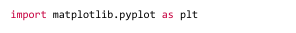
  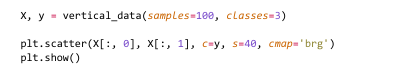
    Using the previously created code up to this point, we can use this new dataset with a simple
neural network:

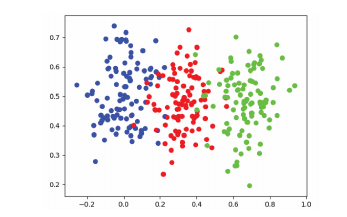
Figure 1: “Vertical data” graphed.

Using the previously created code up to this point, we can use this new dataset with a simple
neural network:

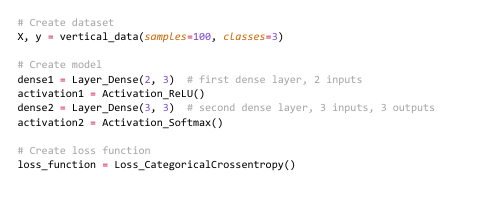

We initialized the loss to a large value and will decrease it when a new, lower, loss is found. We
are also copying weights and biases (​ copy()​ ensures a full copy instead of a reference to the
object). Now we iterate as many times as desired, pick random values for weights and biases, and
save the weights and biases if they generate the lowest-seen loss:

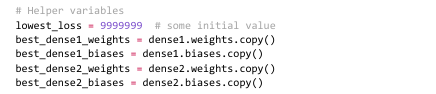

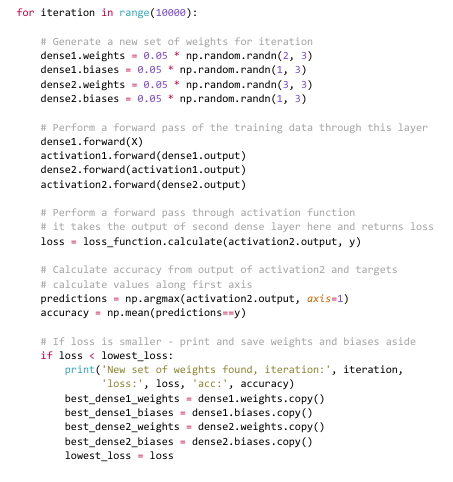

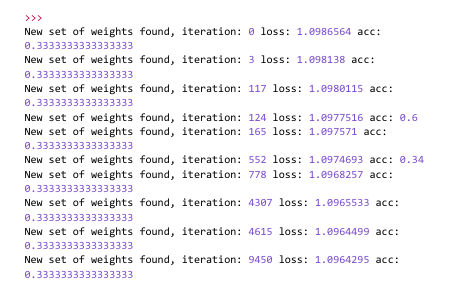
Loss certainly falls, though not by much. Accuracy did not improve, except for a singular
situation where the model randomly found a set of weights yielding better accuracy. Still, with a
fairly large loss, this state is not stable. Running an additional 90,000 iterations for 100,000 in
total:
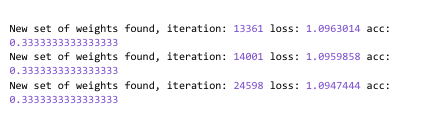
Loss continued to drop, but accuracy did not change. This doesn’t appear to be a reliable method
for minimizing loss. After running for 1 billion iterations, the following was the best (lowest loss)
result:
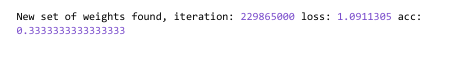
Even with this basic dataset, we see that randomly searching for weight and bias combinations
will take far too long to be an acceptable method. Another idea might be, instead of setting
parameters with randomly-chosen values each iteration, apply a fraction of these values to
parameters. With this, weights will be updated from what currently yields us the lowest loss
instead of aimlessly randomly. If the adjustment decreases loss, we will make it the new point to
adjust from. If loss instead increases due to the adjustment, then we will revert to the previous
point. Using similar code from earlier, we will first change from randomly selecting weights and
biases to randomly ​ adjusting ​ them:

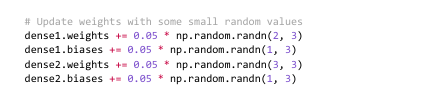
Then we will change our ending ​ if​ s ​ tatement​ t ​ o be:
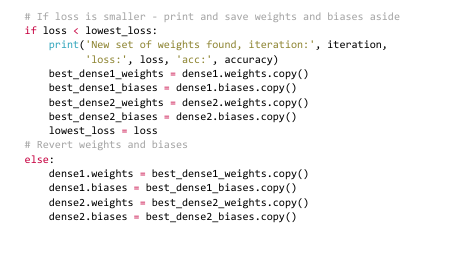

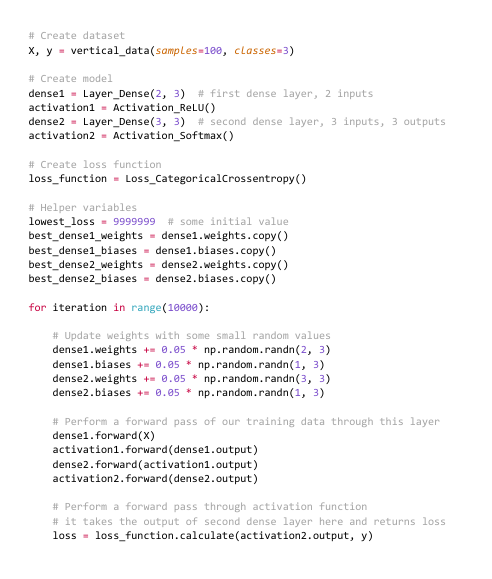


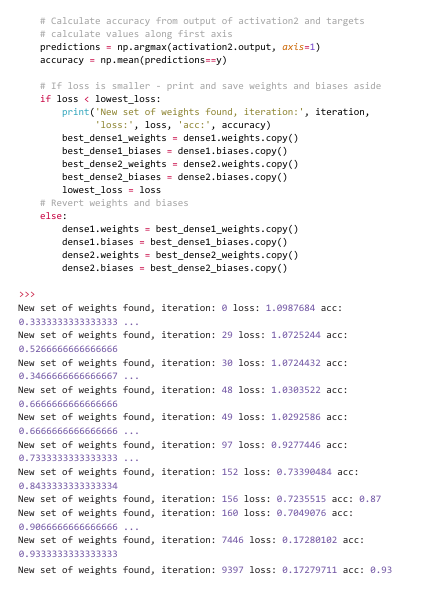

Loss descended by a decent amount this time, and accuracy raised significantly. Applying a
fraction of random values actually lead to a result that we could almost call a solution. If you try
100,000 iterations, you will not progress much further:

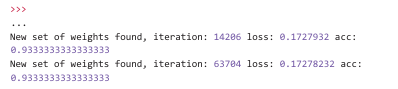


Let’s try this with the previously-seen spiral dataset instead:
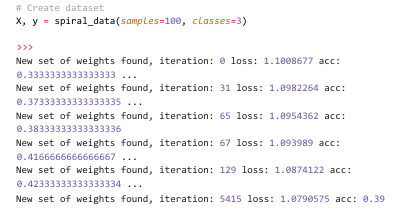

This training session ended with almost no progress. Loss decreased slightly and accuracy is
barely above the initial value. Later, we’ll learn that the most probable reason for this is called a
local minimum of loss. The data complexity is also not irrelevant here. It turns out hard problems
are hard for a reason, and we need to approach this problem more intelligently.

## Steps

### Vertical_data: 
Generates a vertical dataset with multiple classes, where the inputs are positioned in columns.

### Dense layers: 
There are two dense layers, each having weights and biases that are updated with small random perturbations in each iteration.

### ReLU and Softmax activations: 
ReLU is used for the hidden layer, while Softmax is applied to the output layer.

### Loss and accuracy tracking: 
During training, the model updates weights and checks if the current loss is lower than the previous best. If so, it saves the new best weights; otherwise, it reverts to the previous weights.

### Accuracy: 

After each forward pass, the accuracy is computed using np.argmax for the predictions compared to the actual labels.

In [1]:
import numpy as np

# Function to generate vertical data (you can customize this as needed)
def vertical_data(samples, classes):
    X = np.zeros((samples * classes, 2))  # input features
    y = np.zeros(samples * classes, dtype='uint8')  # class labels
    for class_number in range(classes):
        ix = range(samples * class_number, samples * (class_number + 1))
        X[ix] = np.c_[np.linspace(0, 1, samples), np.random.randn(samples) + class_number * 0.2]
        y[ix] = class_number
    return X, y

# Dense layer
class Layer_Dense:
    def __init__(self, n_inputs, n_neurons):
        # Initialize weights and biases
        self.weights = 0.01 * np.random.randn(n_inputs, n_neurons)
        self.biases = np.zeros((1, n_neurons))

    def forward(self, inputs):
        # Calculate output values
        self.output = np.dot(inputs, self.weights) + self.biases

# ReLU activation
class Activation_ReLU:
    def forward(self, inputs):
        self.output = np.maximum(0, inputs)

# Softmax activation
class Activation_Softmax:
    def forward(self, inputs):
        exp_values = np.exp(inputs - np.max(inputs, axis=1, keepdims=True))
        self.output = exp_values / np.sum(exp_values, axis=1, keepdims=True)

# Cross-entropy loss
class Loss_CategoricalCrossentropy:
    def forward(self, y_pred, y_true):
        samples = len(y_pred)
        y_pred_clipped = np.clip(y_pred, 1e-7, 1 - 1e-7)

        if len(y_true.shape) == 1:
            correct_confidences = y_pred_clipped[range(samples), y_true]
        elif len(y_true.shape) == 2:
            correct_confidences = np.sum(y_pred_clipped * y_true, axis=1)

        negative_log_likelihoods = -np.log(correct_confidences)
        return negative_log_likelihoods

    def calculate(self, y_pred, y_true):
        sample_losses = self.forward(y_pred, y_true)
        return np.mean(sample_losses)

# Create dataset
X, y = vertical_data(samples=100, classes=3)

# Create model
dense1 = Layer_Dense(2, 3)  # first dense layer, 2 inputs
activation1 = Activation_ReLU()
dense2 = Layer_Dense(3, 3)  # second dense layer, 3 inputs, 3 outputs
activation2 = Activation_Softmax()

# Create loss function
loss_function = Loss_CategoricalCrossentropy()

# Helper variables
lowest_loss = 9999999  # some initial value
best_dense1_weights = dense1.weights.copy()
best_dense1_biases = dense1.biases.copy()
best_dense2_weights = dense2.weights.copy()
best_dense2_biases = dense2.biases.copy()

# Training loop
for iteration in range(10000):
    # Update weights with some small random values
    dense1.weights += 0.05 * np.random.randn(2, 3)
    dense1.biases += 0.05 * np.random.randn(1, 3)
    dense2.weights += 0.05 * np.random.randn(3, 3)
    dense2.biases += 0.05 * np.random.randn(1, 3)

    # Perform forward pass
    dense1.forward(X)
    activation1.forward(dense1.output)
    dense2.forward(activation1.output)
    activation2.forward(dense2.output)

    # Calculate loss
    loss = loss_function.calculate(activation2.output, y)

    # Calculate accuracy
    predictions = np.argmax(activation2.output, axis=1)
    accuracy = np.mean(predictions == y)

    # If the loss is smaller, print and save the weights and biases
    if loss < lowest_loss:
        print(f'New set of weights found, iteration: {iteration}, loss: {loss}, acc: {accuracy}')
        best_dense1_weights = dense1.weights.copy()
        best_dense1_biases = dense1.biases.copy()
        best_dense2_weights = dense2.weights.copy()
        best_dense2_biases = dense2.biases.copy()
        lowest_loss = loss
    else:
        # Revert weights and biases to previously saved state
        dense1.weights = best_dense1_weights.copy()
        dense1.biases = best_dense1_biases.copy()
        dense2.weights = best_dense2_weights.copy()
        dense2.biases = best_dense2_biases.copy()


New set of weights found, iteration: 0, loss: 1.0988792768553173, acc: 0.3333333333333333
New set of weights found, iteration: 12, loss: 1.0984880300691433, acc: 0.36333333333333334
New set of weights found, iteration: 14, loss: 1.098401559202444, acc: 0.35
New set of weights found, iteration: 21, loss: 1.0982825324787429, acc: 0.3333333333333333
New set of weights found, iteration: 35, loss: 1.0981409641102322, acc: 0.36
New set of weights found, iteration: 43, loss: 1.0974719858892434, acc: 0.3233333333333333
New set of weights found, iteration: 55, loss: 1.0962074543396845, acc: 0.36
New set of weights found, iteration: 60, loss: 1.0946963018129028, acc: 0.3933333333333333
New set of weights found, iteration: 64, loss: 1.0944859083718703, acc: 0.39666666666666667
New set of weights found, iteration: 66, loss: 1.0938976187008551, acc: 0.37
New set of weights found, iteration: 72, loss: 1.0898958323242227, acc: 0.37333333333333335
New set of weights found, iteration: 81, loss: 1.08972